In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
from R_5_main_simulation import BENCHMARK_SUITE
import R_1_data_generator as data_gen
import R_2_tda_optimizer as tda
import R_3_kde_metrics as metrics
import R_4_visualize as viz
import torch


In [3]:
N_ITERS_TDA = 500
seed = 48840

def set_seeds(seed):
    """
    Sets all random seeds for complete reproducibility.
    """
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    print(f"  All seeds set to {seed}. Using deterministic algorithms.")

In [4]:
DATASETS=[
    "1D_bimodal",
    "2D_clusters",
    "MNIST"
]

In [10]:
def run_job(dataset_name, seed):
    set_seeds(seed)
    
    # 2. Get Config
    config = BENCHMARK_SUITE.get(dataset_name)
    if config is None:
        print(f"Error: Dataset '{dataset_name}' not found in BENCHMARK_SUITE.")
        return

    n_samples = 3500#config['n_samples']
    grid_per_dim = config['grid_per_dim']
    
    # 3. Generate Data
    if dataset_name == 'MNIST':
        data_nd = config['data_func'](seed % 10)
    else:
        data_nd = config['data_func'](n_samples)
    data_torch = torch.tensor(data_nd, dtype=torch.float32)

    # 4. Get all bandwidths
    bandwidths, _ = metrics.get_kde_bandwidths(data_nd, verbose=True)
    
    # TDA method
    bw_tda, losses, density, shape, bounds = tda.optimize_bandwidth_nd(
        data_torch, 
        resolution_per_dim=grid_per_dim, 
        n_iters=N_ITERS_TDA,
        lr=0.01,
        alpha_pe=1.0,
        alpha_tp=1.0,
        lambda_smooth=0.0,
        only_H0=True,
        verbose=False
    )
    bandwidths['TDA'] = bw_tda

    # 5. Create Grid for Metrics
    if dataset_name == 'MNIST':
        # === MNIST MODE ===
        Z_true_norm, linspaces = config["pdf_grid_func"](seed % 10)
        Z_true_norm = Z_true_norm.T

        xs, ys = linspaces
        Xg, Yg = np.meshgrid(xs, ys, indexing='xy')
        grid_points = np.stack([Xg.ravel(), Yg.ravel()], axis=1)
        grid_shape = (len(xs), len(ys))
        grid_bounds = None
        grid_coords = None   # not required
        grid_points_np = grid_points.astype(np.float64)

    else:
        # === ANALYTIC MODE ===
        grid_points, grid_shape, grid_bounds = tda.create_grid_nd(
            data_torch, grid_per_dim
        )
        grid_points_np = grid_points.cpu().numpy()
        linspaces = [np.linspace(b[0], b[1], grid_per_dim) for b in grid_bounds]
        grid_coords = np.meshgrid(*linspaces, indexing='ij')
        Z_true = config['pdf_func'](*grid_coords)
        Z_true_norm = metrics.normalize_pdf_nd(Z_true, linspaces)
        grid_points_np = grid_points.cpu().numpy()

    # 6. Evaluate all KDEs on the grid
    Z_kdes = metrics.evaluate_all_kdes(data_nd, bandwidths, grid_points_np, grid_shape, linspaces)
    for method, Z_kde_norm in Z_kdes.items():
        if dataset_name == 'MNIST' and type(Z_kde_norm) is not int:
            Z_kdes[method] = Z_kde_norm.T
            Z_kde_norm = Z_kdes[method]

    # 8. Visualize
    if config['dims'] == 1:
        viz.visualize_results_nd(data_torch, density, shape, bounds, bw_tda, losses, 
                                name=f"{dataset_name}_seed{seed}_TDA")
    viz.plot_comparison_results(Z_kdes, Z_true_norm, linspaces, bandwidths, data_nd, 
                                name_=f"{dataset_name}_seed{seed}_COMPARE")



### 1D Plots

  All seeds set to 48840. Using deterministic algorithms.
Scott          : 0.2023   (time: 0.00023s)
Silverman      : 0.2142   (time: 0.00006s)
NRR            : 0.2142   (time: 0.00005s)
ML-CV          : 0.2311   (time: 3.18968s)
LSCV           : 0.0100   (time: 37.44746s)
BCV            : 0.0100   (time: 43.09011s)
BotevProj      : 0.2142   (time: 0.00741s)
PluginDiag     : 0.2144   (time: 0.00006s)
ISJ            : 0.0183   (time: 0.00355s)


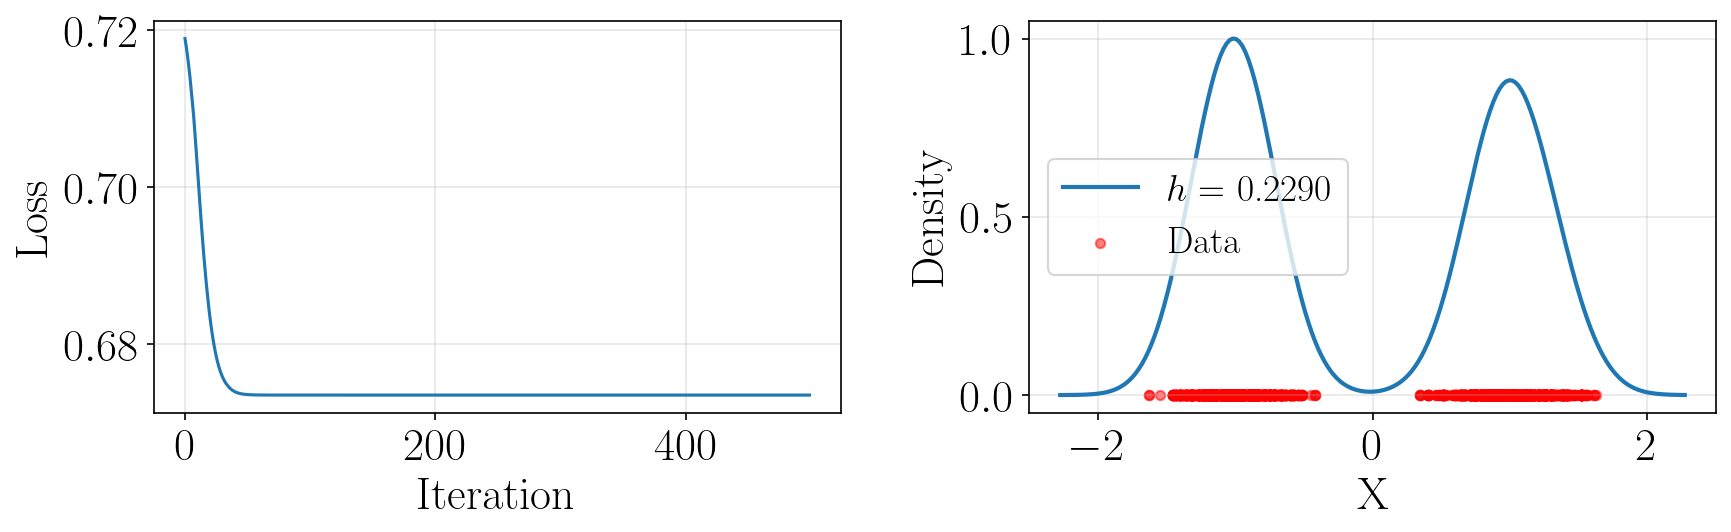

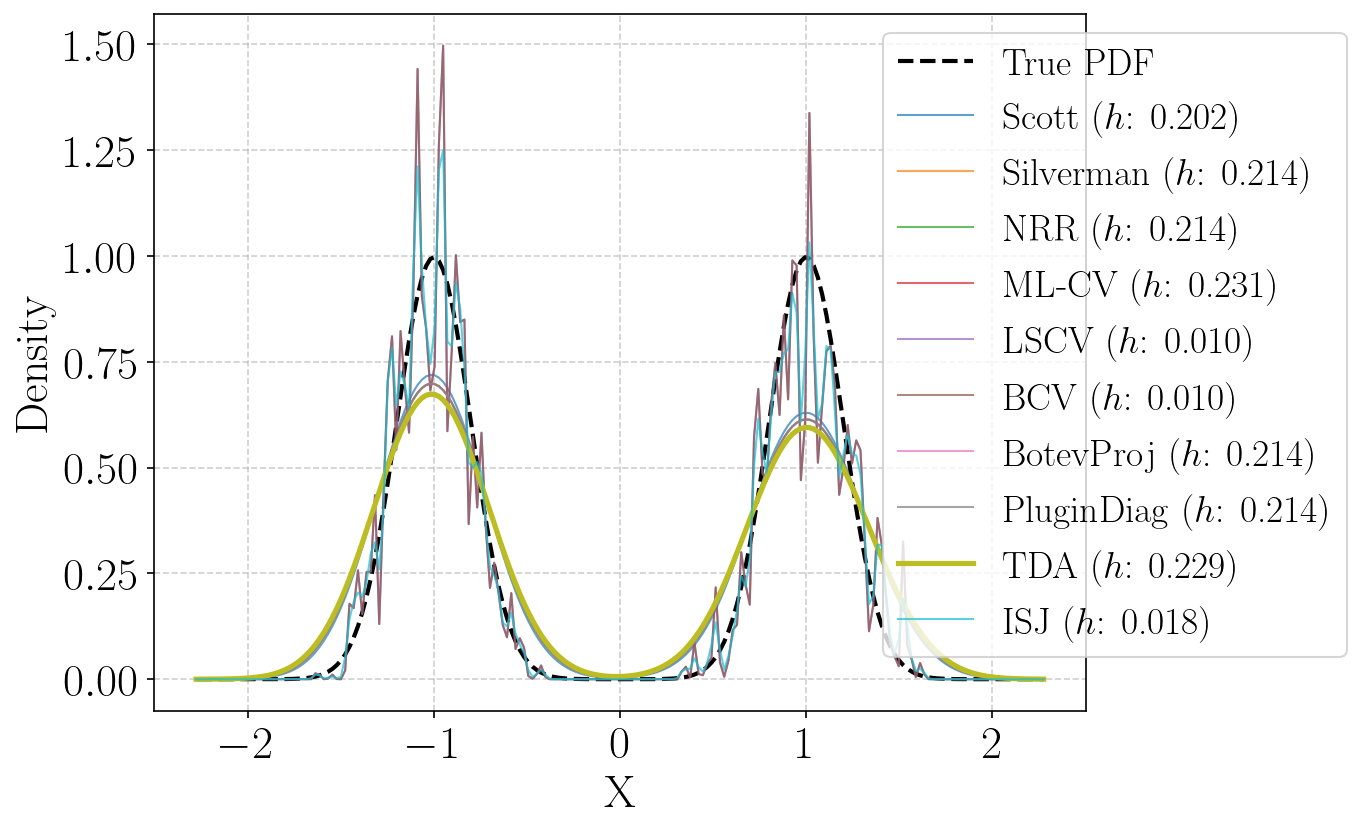

In [6]:
run_job(DATASETS[0], seed)

### 2D Plots

  All seeds set to 48840. Using deterministic algorithms.
Scott          : 0.3483   (time: 0.00016s)
Silverman      : 0.3483   (time: 0.00010s)
NRR            : 0.3483   (time: 0.00010s)
ML-CV          : 0.2311   (time: 3.21754s)
LSCV           : 0.0100   (time: 38.62357s)
BCV            : 0.0100   (time: 44.09491s)
BotevProj      : 0.2876   (time: 0.00767s)
PluginDiag     : 1.4688   (time: 0.72949s)
ISJ            : nan   (time: 0.00000s)


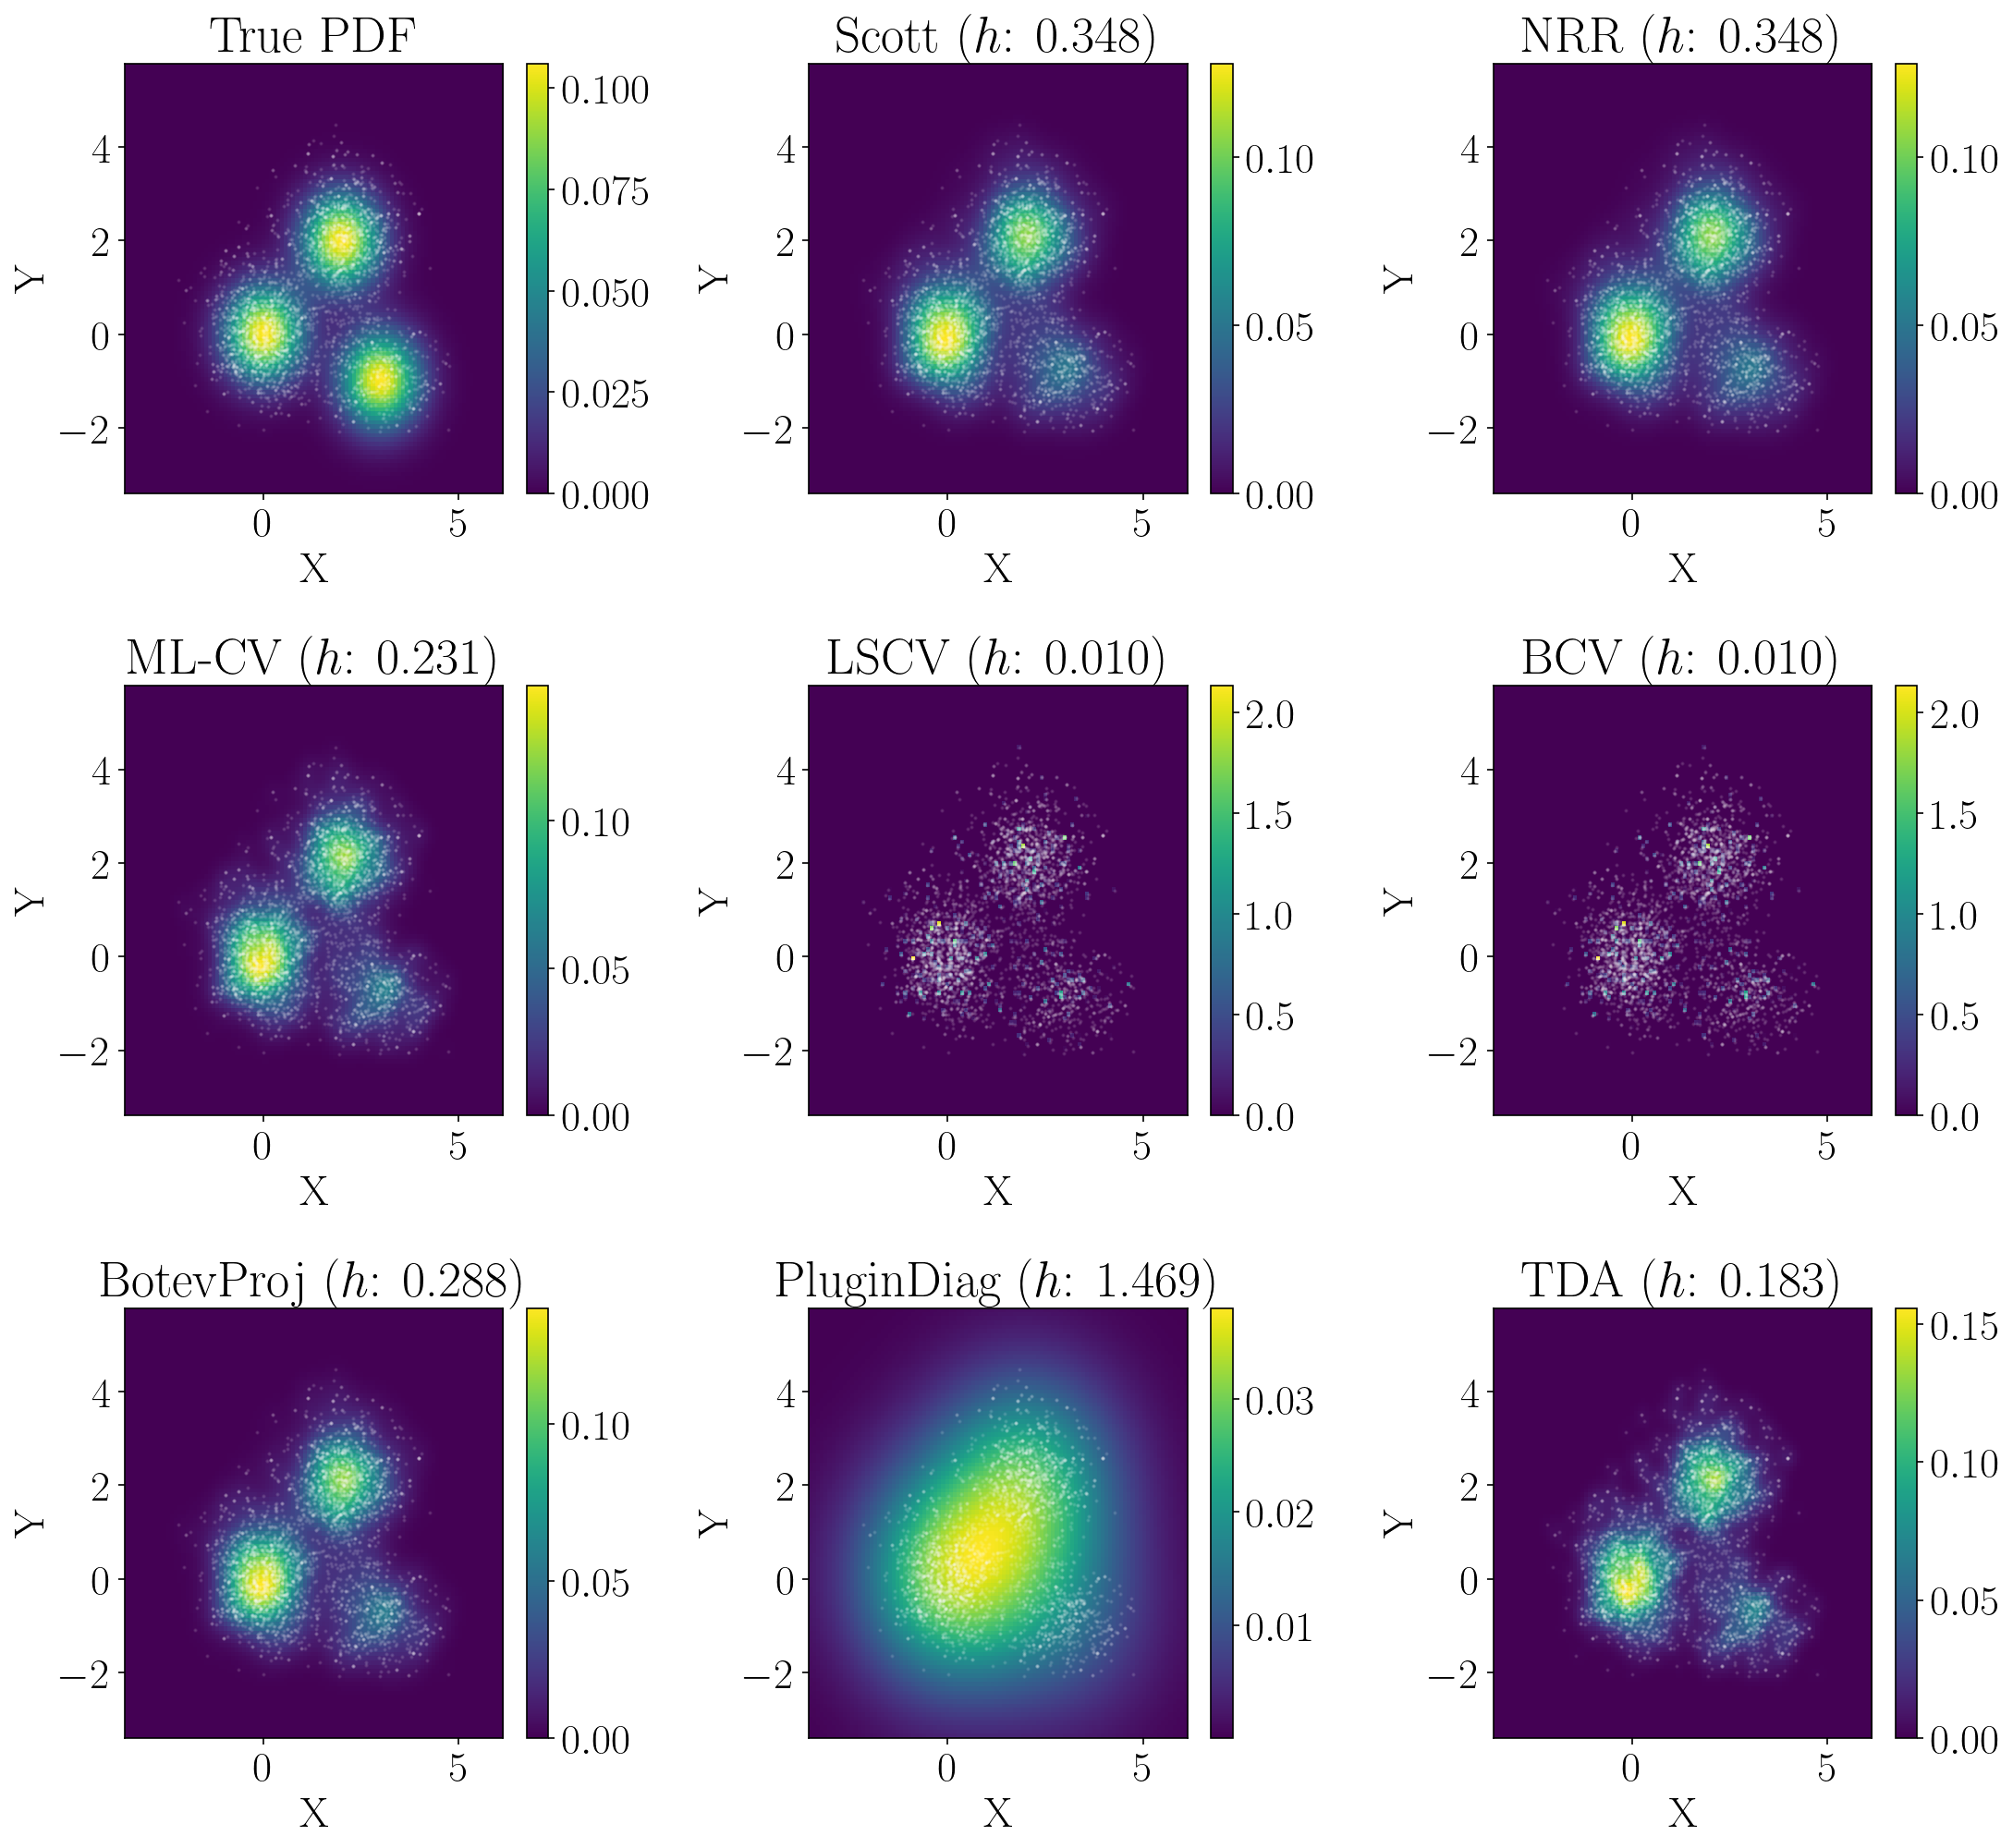

In [11]:
run_job(DATASETS[1], seed)

  All seeds set to 48841. Using deterministic algorithms.
Scott          : 1.3682   (time: 0.00010s)
Silverman      : 1.3682   (time: 0.00004s)
NRR            : 1.3682   (time: 0.00005s)
ML-CV          : 0.4522   (time: 0.04028s)
LSCV           : 0.4522   (time: 0.02932s)
BCV            : 0.0100   (time: 0.02725s)
BotevProj      : 1.4686   (time: 0.00548s)
PluginDiag     : 1.8246   (time: 0.00313s)
ISJ            : nan   (time: 0.00000s)


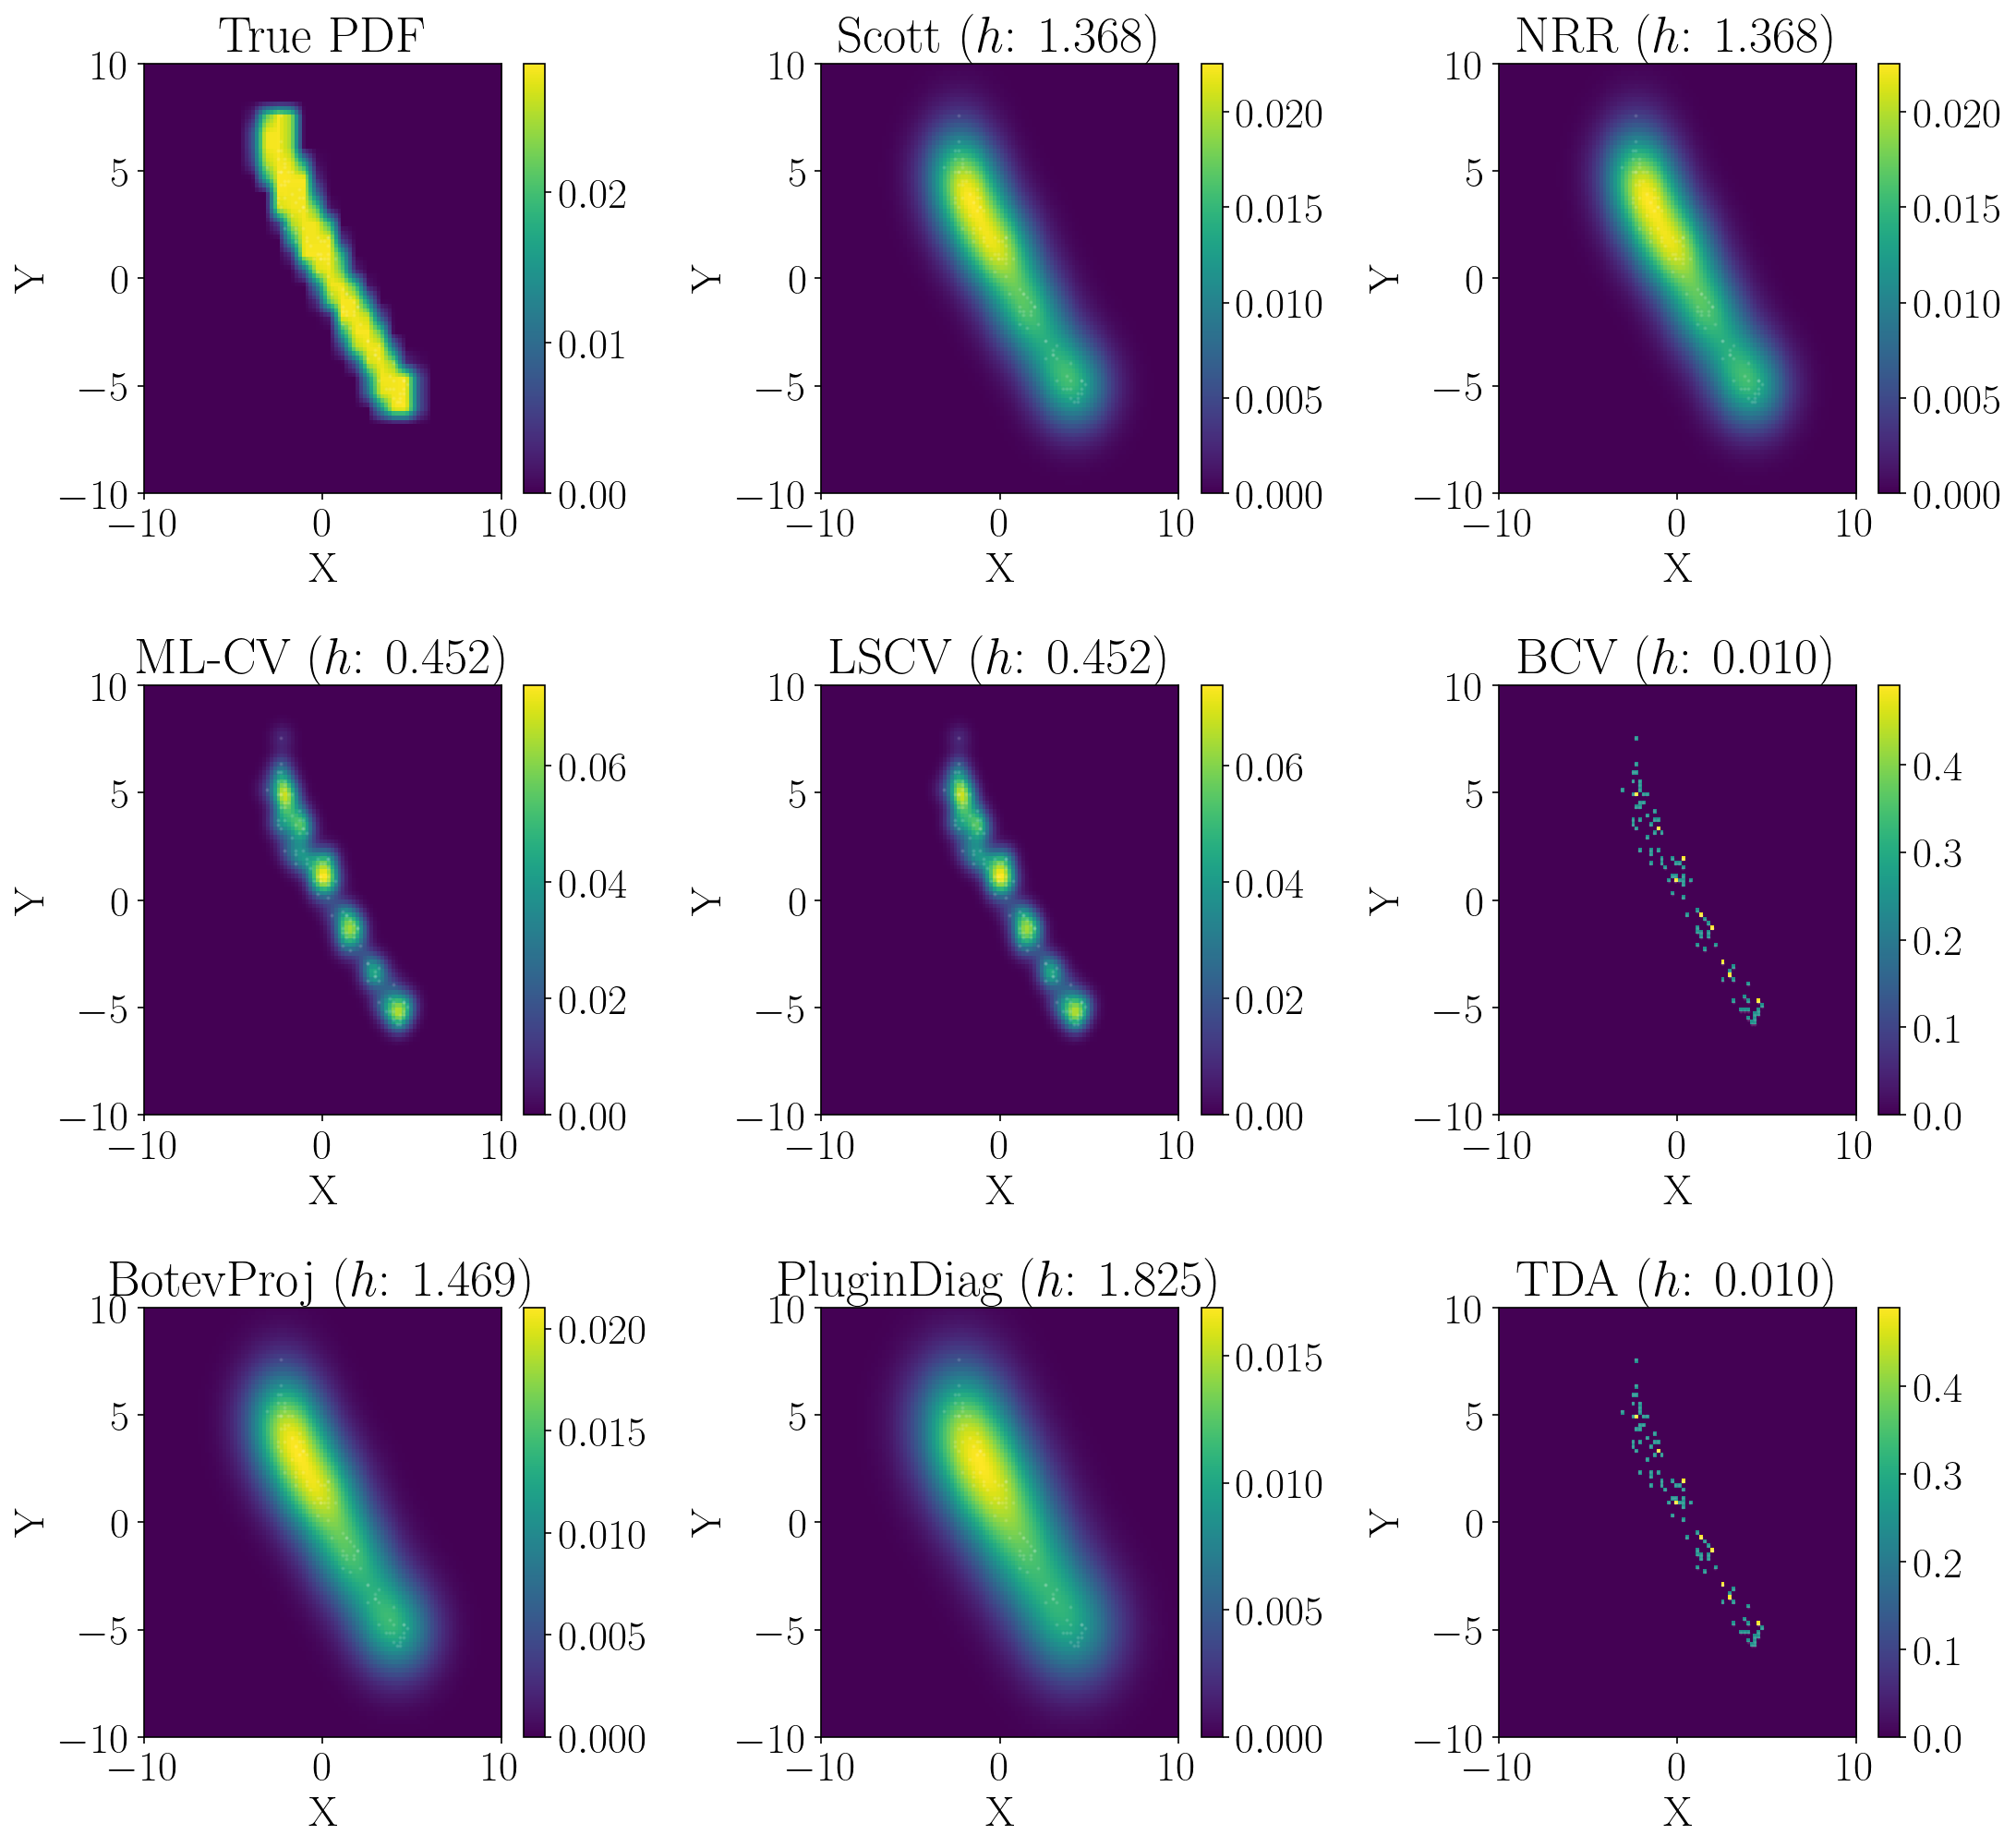

In [12]:
run_job(DATASETS[2], seed+1)